In [1]:
import numpy as np
import matplotlib

# Embed fonts into PDF/PS files
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors

import scipy.integrate
import scipy.optimize

# Make deep copies
import copy

# For 3d plotting
from mpl_toolkits.mplot3d import Axes3D

In [2]:
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial']})

In [3]:
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

# Define parameters

In [4]:
## Physiological parameters

# mvn head sensitvity in the light: 0.38 sp/s / deg/s for ~0.85 gain -- Beraneck & Cullen 2007
# => k_eye ~= 2.2

# Eye movement response to optogenetic stimulation (Payne et al. 2019)
# ~0.1 deg/s / sp/s = k_eye * w_PC => w_PC ~= 0.05

# memory retention ~75% after 24 hr calculated from Boyden & Raymond 2003

params = {
    'mf_0': 55, # Lasker et al. 2008
    'pf_0': 14, # Arenz et al. 2008 -- assume each MF EPSC evokes a GC spike
    'cf_0': 1,
    'mf_sensitivity': 0.14, # Lasker et al. 2008
    'k_pf_h': 0.42, # Arenz et al. 2008 (See above)
    'k_pf_e': 0.42,
    'w_inh_h': 5, # match feedforward model
    'w_pc_mvn': 0.05, # Payne et al. 2019
    'k_eye': 2.2,
    'k_v': 4.1e-3, # 0.01 # to get 75% retention
    'tau_f': 0.017, # fast average
    'tau_mvn': 0.7, # 0.7 # tau_f,v: average of activity being integrated at MVN
    'k_LTD_h': 0.725, # 1.75
    'k_LTD_e': 0.725,
    'beta_rs': 1, # to match the sensitivity measured in Guo et al. 2014
    'beta_homeo':0.0125,
    'w_inh_e': 2,
}

# for eye sensitivity of 2.7 sp/s/(deg/s), Katoh et al. 2015, given PF sensitivity above
params['w_eye'] = params['w_inh_e'] + 2.7/params['k_pf_h']
params['k_LTP_h'] = params['k_LTD_h']*params['cf_0']
params['k_LTP_e'] = params['k_LTD_e']*params['cf_0']

## Behavioral parameters

# Kimpo et al. 2014, Nguyen-Vu et al. 2013, Boyden & Raymond 2003
stim_freq = 1 
peak_velocity_learn = 15 # deg/s
peak_velocity_post = 15

# Define function for head velocity
head_learn = lambda t: peak_velocity_learn*np.sin(2*np.pi*stim_freq*3600*t)
head_post_input = lambda t: peak_velocity_post*np.sin(2*np.pi*stim_freq*3600*t) # w/post-training input

In [13]:
gain = lambda w_h, w_e, v: params['k_eye']*((params['mf_sensitivity']*v - 
                                    params['k_pf_h']*params['w_pc_mvn']*(w_h)) / 
                                    (1 - params['w_pc_mvn']*params['k_pf_e']*params['k_eye']*(w_e)))

In [21]:
# initial gain ~- 0.4 in mice (Katoh et al. 2015, Boyden & Raymond 2003)
g_init = 0.4

# Given the measured value of PC sensitivity to eye velocity, calculate value of w_H
# needed for synaptic weights to be at steady state pre-training as a function of initial gain
w_e_tilde = params['k_pf_e']*(params['w_eye']-params['w_inh_e'])
w_h_0_ = lambda g_init: g_init * w_e_tilde/params['k_pf_h']

# Calculate corresponding value of v
v_0_ = lambda w_h_0: w_h_0*params['k_pf_h']/(params['k_eye']*w_e_tilde*params['mf_sensitivity'])
# v_0_ = lambda g_init: g_init/(params['k_eye']*params['mf_sensitivity'])

In [31]:
# Value of w_H for a starting gain of 0.4
w_h_0_init = w_h_0_(g_init)
print(w_h_0_init)

2.5714285714285716


In [32]:
w_h_0 = 2.5

For simplicity of plotting, we set the initial value of $w_H$ to 2.5, which leads to an initial value of $v$:

In [33]:
v_0 = v_0_(w_h_0)
print(v_0)

1.2626262626262623


and starting gain:

In [34]:
gain(w_h_0, params['w_eye']-params['w_inh_e'], v_0)

0.38888888888888884

In [35]:
# Spontaneous firing rate of PCs ~50 sp/s (Katoh et al. 2015) 
# and MVNs is ~57 sp/s (Nelson et al. 2003)

# Calculate PC and MVN offsets so that this is the firing rate at baseline
params['pc_0'] = 50 - params['pf_0']*(w_h_0 + params['w_eye']-params['w_inh_e'])
params['mvn_0'] = 57 - params['mf_0']*v_0 + params['w_pc_mvn']*50

In [36]:
params['pc_0'], params['mvn_0']

(-75.0, -9.944444444444429)

# ODE Solver

We model the evolution of the state `y`, which has nine components: `y[0]` is $w_H$, `y[1]` is $v$, `y[2]` is $\langle\text{MF}(\text{PC}-\langle\text{PC}\rangle)\rangle$, `y[3]` is $\langle\text{PF}_H\rangle$, `y[4]` is $\langle\text{PF}_H\cdot\text{CF}\rangle$, `y[5]` is $\langle\text{PC}\rangle$, `y[6]` is $w_E$, `y[7]` is $\langle\text{PF}_E\rangle$ and `y[8]` is $\langle\text{PF}_E\cdot\text{CF}\rangle$. The evolution is defined according to the "inhibition of instructive signals reset mechanism" in SI Appendix, S6.

In [48]:
# Function to pass to ODE solver
def homeostaticCF_Feedback3D(t, y, head, target_gain, learn, params):
    '''
    head: a function taking a time argument that returns the head velocity
    target_gain: scalar value of target input-to-output gain
    learn: set to True if in the training period, False if in the post-training period
    params: list containing the physiological parameters
    
    '''
    w_h_exc = y[0]
    w_e_exc = y[6]
    w_h = w_h_exc - params['w_inh_h']
    w_e = w_e_exc - params['w_inh_e']
    
    v = y[1]
    theta = y[5]
    
    current_gain = params['k_eye']*((params['mf_sensitivity']*v - 
                                    params['k_pf_h']*params['w_pc_mvn']*(w_h)) / 
                                    (1 - params['w_pc_mvn']*params['k_pf_e']*params['k_eye']*w_e))
    eye = -current_gain * head(t)
    
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf_h = params['k_pf_h']*head(t)
    delta_pf_e = params['k_pf_e']*eye
    
    mf = params['mf_0'] + delta_mf
    pf_h = params['pf_0'] + delta_pf_h
    pf_e = params['pf_0'] + delta_pf_e
    
    pc = params['pc_0'] + w_h*pf_h + w_e*pf_e
    delta_pc = pc - theta
    
    rs = -(target_gain - current_gain)*head(t)
    delta_cf = np.tanh(-params['beta_rs']*rs*learn + params['beta_homeo']*delta_pc)
    cf = params['cf_0'] + delta_cf
    
    dydt = np.zeros(9)
    # w_H, v, <MF(PC-<PC>)>, <PF_H>, <PF_H*CF>, <PC>, w_E, <PF_E>, <PF_E*CF>
    dydt[0] = params['k_LTP_h']*y[3]-params['k_LTD_h']*y[4]
    dydt[1] = params['k_v']*(-y[2])
    dydt[2] = 1/params['tau_mvn'] * (-y[2] + mf*(pc - theta))
    dydt[3] = 1/params['tau_f'] * (-y[3] + pf_h)
    dydt[4] = 1/params['tau_f'] * (-y[4] + pf_h*cf)
    dydt[5] = 1/params['tau_f'] * (-y[5] + pc)
    dydt[6] = params['k_LTP_e']*y[7] - params['k_LTD_e']*y[8]
    dydt[7] = 1/params['tau_f'] * (-y[7] + pf_e)
    dydt[8] = 1/params['tau_f'] * (-y[8] + pf_e*cf)
    
    return dydt

# Jacobian 
def homeostaticCF_Feedback3D_Jac(t, y, head, target_gain, learn, params):
    
    w_h_exc = y[0]
    w_e_exc = y[6]
    w_h = w_h_exc - params['w_inh_h']
    w_e = w_e_exc - params['w_inh_e']
    
    v = y[1]
    theta = y[5]
    
    w_e_ = params['k_eye']*params['k_pf_e']*w_e
    d = 1 - params['w_pc_mvn']*w_e_
    
    current_gain = params['k_eye']*((params['mf_sensitivity']*v - 
                                    params['k_pf_h']*params['w_pc_mvn']*(w_h)) / d)
    eye = -current_gain * head(t)
    
    
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf_h = params['k_pf_h']*head(t)
    delta_pf_e = params['k_pf_e']*eye
    
    
    mf = params['mf_0'] + delta_mf
    pf_h = params['pf_0'] + delta_pf_h
    pf_e = params['pf_0'] + delta_pf_e
    
    pc = params['pc_0'] + w_h*pf_h + w_e*pf_e
    delta_pc = pc - theta
    
    rs = -(target_gain - current_gain)*head(t)
    rs = -(target_gain - current_gain)*head(t)
    delta_cf = np.tanh(-params['beta_rs']*rs*learn + params['beta_homeo']*delta_pc)
    cf = params['cf_0'] + delta_cf
    
    
    dg_dwh = -params['k_eye']*params['w_pc_mvn']*params['k_pf_h']/d
    dg_dv = params['k_eye']*params['mf_sensitivity']/d
    dg_dwe = current_gain * params['w_pc_mvn']*params['k_eye']*params['k_pf_e'] / d
    
    dpc_dwh = params['pf_0'] + params['k_pf_h']/d*head(t)
    dpc_dv = - w_e_*params['mf_sensitivity']/d*head(t)
    dpc_dwe = params['pf_0'] + params['k_pf_e']/d*(-dg_dwe * head(t))

    K_h = pf_h*(1 - delta_cf**2)
    K_e = pf_e*(1 - delta_cf**2)
    K_C = -params['cf_0']*params['k_pf_e']*head(t)
    K_T = params['k_pf_e']*head(t)*delta_cf
    
    jac = np.zeros((9,9))
    # w_H, v, <MF(PC-<PC>)>, <PF_H>, <PF_H*CF>, <PC>, w_E, <PF_E>, <PF_E*CF>
    
    jac[0,3:5] = np.array([params['k_LTP_h'], -params['k_LTD_h']])
    jac[1,2] = -params['k_v']
    jac[2,:] = 1/params['tau_mvn']*np.array([mf*dpc_dwh, mf*dpc_dv, -1, 0,0,-mf,mf*dpc_dwe,0,0])
    jac[3,3] = -1/params['tau_f']
    jac[4,:] = 1/params['tau_f']*np.array([K_h*(-params['beta_rs']*learn*dg_dwh*head(t) + 
                                                    params['beta_homeo']*(dpc_dwh - theta)),
                                                K_h*(-params['beta_rs']*learn*dg_dv*head(t) +
                                                   params['beta_homeo']*(dpc_dv - theta)),
                                                0, 0, -1, -K_h*params['beta_homeo'], 
                                                K_h*(-params['beta_rs']*learn*dg_dwe*head(t) + 
                                                    params['beta_homeo']*(dpc_dwe - theta)),
                                                0, 0])
    
    jac[5,:] = 1/params['tau_f']*np.array([dpc_dwh, dpc_dv, 0, 0, 0, -1, dpc_dwe, 0, 0])
    jac[6,6:8] = np.array([params['k_LTP_e'], -params['k_LTD_e']])
    jac[7,7] = -1/params['tau_f']
    jac[8,:] = 1/params['tau_f']*np.array([K_C*dg_dwh + K_e*(-params['beta_rs']*learn*dg_dwh*head(t) + 
                                                    params['beta_homeo']*(dpc_dwh - theta)) -
                                                    K_T * dg_dwh,
                                           K_C*dg_dv + K_e*(-params['beta_rs']*learn*dg_dv*head(t) +
                                                   params['beta_homeo']*(dpc_dv - theta)) -
                                                   K_T * dg_dv,
                                                0, 0, 0, -K_e*params['beta_homeo'], 
                                                K_C*dg_dwe + K_e*(-params['beta_rs']*learn*dg_dwe*head(t) + 
                                                    params['beta_homeo']*(dpc_dwe - theta)) - 
                                                   K_T * dg_dwe,
                                                0, -1])
    return jac

# Run simulation

In [38]:
## Set initial conditions for simulation
theta_0 = params['pc_0'] + params['pf_0']*(w_h_0 + params['w_eye']-params['w_inh_e'])

# w_H, v, <MF(PC-<PC>)>, <PF_H>, <PF_H*CF>, <PC>, w_E, <PF_E>, <PF_E*CF>
y_0 = np.array([w_h_0 + params['w_inh_h'], v_0, 0, params['pf_0'], params['pf_0']*params['cf_0'],
                theta_0, params['w_eye'], params['pf_0'], params['pf_0']*params['cf_0']])

In [29]:
g_des = 2 # target gain during training

In [39]:
T_learn = 0.5 # h

T_post = 24 # s

## Time steps for plotting (ODE solver uses variable time steps)

dt_learn = 1/3600 # h (= 1 s)
dt_post = 10*60/3600 # h (= 10 min)

t_learn = np.linspace(0, T_learn, int(T_learn/dt_learn))
t_post = np.linspace(0, T_post-T_learn, int(T_post/dt_post)) + T_learn


# Solution during the training period
sol_learn = scipy.integrate.solve_ivp(lambda t,y: homeostaticCF_Feedback3D(t,y, head_learn, g_des, True, params), [0, T_learn], y_0, 
                                  jac=lambda t,y: homeostaticCF_Feedback3D_Jac(t,y,head_learn, g_des,True,params), method='Radau', dense_output=True, max_step=0.25*1/3600)

y_learn = sol_learn.sol(t_learn)

sol_recov = scipy.integrate.solve_ivp(lambda t,y: homeostaticCF_Feedback3D(t,y, head_post_input, g_des, False, params), [T_learn, T_post], y_learn[:,-1], 
                                  jac=lambda t,y: homeostaticCF_Feedback3D_Jac(t,y,head_post_input,
                                                             g_des,False,params), method='Radau', dense_output=True, max_step=0.25*1/3600)


y_recov = sol_recov.sol(t_post)

In [40]:
t_ = np.concatenate((t_learn, t_post))
y_ = np.hstack((y_learn, y_recov))

In [41]:
w_H = y_[0,:] - params['w_inh_h']
w_E = y_[6,:] - params['w_inh_e']

# Figure S3B

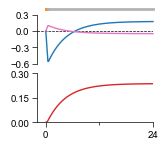

In [42]:
plt.figure(figsize=(1.5,1.4))

ax = plt.subplot(2,1,1)

plt.plot([-2,24], [0,0],'k--',lw=0.5)

plt.plot([0, 0.5],[0.4,]*2,  c='C1', lw=2, clip_on=False)
plt.plot([0.5, 24], [0.4,]*2,  c=(0.7,)*3, lw=2, clip_on=False)

plt.plot(t_, (w_H-w_H[0])/w_H[0], c='C0', clip_on=False,lw=1)
plt.plot(t_, (w_E-w_E[0])/w_E[0], c='C6', clip_on=False,lw=1)
# plt.plot(t_, (y_[6,:]-y_[6,0])/y_[6,0], c='C9', clip_on=False,lw=1)
plt.ylim([-0.6, 0.3])
plt.xlim([-2,24])
ax.xaxis.set_visible(False)

ax.set_yticks([0.3, 0, -0.3, -0.6])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = plt.subplot(2,1,2)
plt.plot(t_, (y_[1,:]-y_[1,0])/y_[1,0], c='C3',lw=1)

plt.ylim([0, 0.3])
plt.xlim([-2,24])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 0.15,0.3])

ax.set_xticks([0,12,24])
ax.set_xticks([0, 24])
ax.set_xticks([12], minor=True)

# Figure S3C,D

In [43]:
# Calculate percent gain change consolidated
gain_learn = gain(y_learn[0,:]-params['w_inh_h'], y_learn[6,:]-params['w_inh_e'], y_learn[1,:])
gain_post = gain(y_recov[0,:]-params['w_inh_h'],y_recov[6,:]-params['w_inh_e'], y_recov[1,:])
print((gain_post[-1]-gain_learn[0])/(gain_learn[-1]-gain_learn[0]))

0.7744960230603085


In [44]:
gain_ = gain(w_H, w_E, y_[1,:])
gain_v = y_[1,:]*params['mf_sensitivity']*params['k_eye'] # gain(w_H[0], y_[1,:])

In [45]:
# Calculate change in PC sensitivity to head velocity, relative to sliding average
delta_pc_sens = lambda w_H, w_E, v: ((params['k_pf_h']*w_H - params['k_eye']*params['k_pf_e']*w_E*params['mf_sensitivity']*v)/
            (1 - params['w_pc_mvn']*params['k_eye']*params['k_pf_e']*w_E))


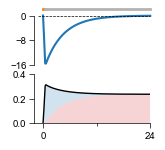

In [47]:
plt.figure(figsize=(1.5,1.4))

ax = plt.subplot(2,1,1)

plt.plot(t_, delta_pc_sens(w_H, w_E, y_[1,:])*peak_velocity_post,clip_on=False)
plt.plot([-1,24], [0,0],c='k',ls='--',lw=0.5, clip_on=False)

plt.plot([0, T_learn], [2,]*2, c='C1', lw=2, clip_on=False)
plt.plot([T_learn, T_post], [2,]*2, c=(0.7,)*3, lw=2, clip_on=False)
# plt.ylim()
plt.ylim([-16, 0])
plt.xlim([-2,24])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)

plt.yticks([0, -8, -16])

ax = plt.subplot(2,1,2)
plt.fill_between(t_, np.zeros(len(t_)), gain_v/gain_v[0]-1, facecolor='C3',alpha=0.2)
plt.fill_between(t_, gain_v/gain_v[0]-1,gain_/gain_[0]-1,  facecolor='C0',alpha=0.2 )
plt.plot(t_, gain_/gain_[0]-1, c='k',lw=1)

# plt.plot([0, 0.5],[0.4,]*2,  c='C1', lw=2, clip_on=False)
# plt.plot([0.5, 24], [0.4,]*2,  c=(0.7,)*3, lw=2, clip_on=False)


plt.ylim([0, 0.4])
plt.xlim([-2,24])
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 24])
ax.set_xticks([12], minor=True)
ax.set_xticklabels([0, 24])

# Figure S3E

In [200]:
# Continuum of stable states of the dynamics
attractor_surface = lambda w_h, w_e: np.divide(w_h*params['k_pf_h'],(w_e*params['k_eye']*params['k_pf_e']*params['mf_sensitivity']))

In [201]:
sigma2 = 0.5*peak_velocity_post**2

To plot the flow field, we need to estimate the derivatives. We use the following approximation.

As for the non-plastic feedback case, we estimate $\text{d}w_H/\text{d}t$ in the post-training period as 
$$
\frac{\text{d}w_H}{\text{d}t} \approx -k_\text{LTD}k_{PH}\langle\dot{H}(t)\tanh(\beta_\text{dark}\delta\text{PC}(t))\rangle \approx -\frac{1}{T}k_\text{LTD}k_{PF}\int_0^T\text{d}t\ \dot{H}(t)\tanh\left(\beta_\text{dark}\frac{\tilde{w}_H - k_E \tilde{w}_E v}{1-w_\text{PC}k_E\tilde{w}_E}\dot{H}(t)\right),
$$
where $k_{PH} = k_{\text{PF},H}$ for convenience.

Now, we similarly esimate $\text{d}w_E/\text{d}t$ as
$$
\begin{align*}
\frac{\text{d}w_E}{\text{d}t} \approx -k_\text{LTD}k_{PE}\langle\dot{E}(t)\tanh(\beta_\text{dark}\delta\text{PC}(t))\rangle &= k_\text{LTD}k_{PE}\cdot g\langle \dot{H}(t)\tanh(\beta_\text{dark}\delta\text{PC}(t))\rangle
\end{align*}
$$

In [279]:
T_avg = 0.5/3600 # one half cycle at 1 Hz
avg_equation = lambda t,w_H,w_E,v: head_post_input(t)*np.tanh(params['beta_homeo']*delta_pc_sens(w_H,w_E,v)*head_post_input(t))

dwHdt_approx = lambda w_H,w_E,v: -1/T_avg*params['k_LTD_h']*params['k_pf_h']*scipy.integrate.quad(lambda t: avg_equation(t,w_H,w_E,v), 0, T_avg)[0]
dwEdt_approx = lambda w_H,w_E,v: 1/T_avg*params['k_LTD_e']*params['k_pf_e']*gain(w_H,w_E,v)*scipy.integrate.quad(lambda t: avg_equation(t,w_H,w_E,v), 0, T_avg)[0]

dwhdt_approx_vec = np.vectorize(dwHdt_approx)
dwedt_approx_vec = np.vectorize(dwEdt_approx)

To plot the surface of fixed points:

In [205]:
n_points_v = 10
n_points_whwe = 10

In [247]:
# Calculate value of w_H corresponding to a pair (w_E, v) along the surface of fixed points
wh_ = lambda w_E, v: 1/params['k_pf_h']*params['k_eye']*params['k_pf_e']*w_E*params['mf_sensitivity']*v

In [262]:
v_ = lambda w_H, w_E: params['k_pf_h']*w_H/(params['k_eye']*params['k_pf_e']*w_E*params['mf_sensitivity'])

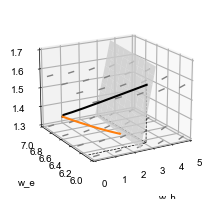

In [343]:
fig = plt.figure(figsize=(2.25,2.25))
ax = fig.add_subplot(projection='3d')
ax.computed_zorder = False

# Axis limits
xlims = [0, 5]
xlimrange = xlims[1]-xlims[0]
ylims = [6,7]
ylimrange = ylims[1]-ylims[0]
zlims = [1.3, 1.7]
zlimrange = zlims[1]-zlims[0]

# Plotting the surface

v_surf = np.linspace(0,1,n_points_v)*zlimrange + zlims[0]
we_surf = np.linspace(0,1,n_points_whwe)*ylimrange + ylims[0]


we_surf_full, v_surf_full = np.meshgrid(we_surf, v_surf)
wh_surf_full = wh_(we_surf_full, v_surf_full)

ax.plot_surface(wh_surf_full, we_surf_full, v_surf_full, zorder=-2, facecolor=(0.8,0.8,0.8),alpha=0.8)

# Plot trajectories
ax.plot( y_recov[0,:]-params['w_inh_h'], y_recov[6,:]-params['w_inh_e'], y_recov[1,:], c='k', zorder=1)
ax.plot( sol_learn.y[0,:]-params['w_inh_h'],sol_learn.y[6,:]-params['w_inh_e'],  sol_learn.y[1,:], c='C1', zorder=2)


# Plot flow field
wh_phase, we_phase, vv_phase = np.meshgrid(xlims[0] + np.linspace(0.05,0.95, 5)*xlimrange,
                                          ylims[0] + np.linspace(0.05,0.95,4)*ylimrange,
                                          zlims[0] + np.linspace(0,0.67,2)*zlimrange)

dwhdt = dwhdt_approx_vec(wh_phase, we_phase, vv_phase)
dwedt = dwedt_approx_vec(wh_phase, we_phase, vv_phase)

dvdt = -params['k_v']*(params['mf_sensitivity']*delta_pc_sens(wh_phase, we_phase, vv_phase)*sigma2)

dwh_ = dwhdt/np.sqrt(dwhdt**2 + dwedt**2 + dvdt**2)
dwe_ = dwedt/np.sqrt(dwhdt**2 + dwedt**2 + dvdt**2)
dv_ = dvdt/np.sqrt(dwhdt**2 + dwedt**2 + dvdt**2)

# Make phase arrows behind surface of fixed points transparent
mask_wewh = (we_phase > params['k_pf_h']*wh_phase/(params['k_eye']*params['k_pf_e']*params['mf_sensitivity']*vv_phase))

ax.quiver(wh_phase[mask_wewh], we_phase[mask_wewh], vv_phase[mask_wewh], dwh_[mask_wewh], dwe_[mask_wewh], dv_[mask_wewh], 
          length=0.15, arrow_length_ratio=0,
           normalize=True, pivot='middle', color=(0.5,)*3, lw=1, zorder=0)
ax.quiver(wh_phase[~mask_wewh], we_phase[~mask_wewh], vv_phase[~mask_wewh], dwh_[~mask_wewh], dwe_[~mask_wewh], dv_[~mask_wewh], 
          length=0.15, arrow_length_ratio=0,
           normalize=True, pivot='middle', color=(0.5,)*3, lw=1, zorder=-3)

ax.plot([w_H[-1],]*2, [w_E[-1],]*2, [zlims[0], y_[1,-1]], c='k', lw=0.5, ls='--',zorder=-3)
ax.plot([w_H[-1],]*2, [w_E[-1], ylims[1]], [zlims[0],]*2, c='k', lw=0.5, ls='--',zorder=-3)
ax.plot([xlims[0], w_H[-1]], [w_E[-1],]*2, [zlims[0],]*2, c='k', lw=0.5, ls='--',zorder=-3)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_zlim(zlims)

ax.view_init(18, 240)
plt.ylabel('w_e')
plt.xlabel('w_h')
ax.set_frame_on(b=False)

For an en-face view of the phase arrows

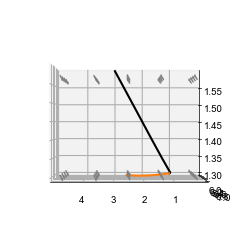

In [340]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(projection='3d')

ax.plot( sol_recov.y[0,:]-params['w_inh_h'], sol_recov.y[6,:]-params['w_inh_e'], sol_recov.y[1,:], c='k', zorder=1)
ax.plot( sol_learn.y[0,:]-params['w_inh_h'],sol_learn.y[6,:]-params['w_inh_e'],  sol_learn.y[1,:], c='C1', zorder=2)


ax.quiver(wh_phase[mask_wewh], we_phase[mask_wewh], vv_phase[mask_wewh], dwh_[mask_wewh], dwe_[mask_wewh], dv_[mask_wewh], 
          length=0.1, arrow_length_ratio=0.15,
           normalize=True, pivot='middle', color=(0.5,)*3, lw=1, zorder=0)
ax.quiver(wh_phase[~mask_wewh], we_phase[~mask_wewh], vv_phase[~mask_wewh], dwh_[~mask_wewh], dwe_[~mask_wewh], dv_[~mask_wewh], 
          length=0.1, arrow_length_ratio=0.15,
           normalize=True, pivot='middle', color=(0.5,)*3, lw=1, zorder=-3)
ax.view_init(0,90)
